# 문제3: 결측치, 이상치 확인 및 시각화

## 수행목표

- KMRD 데이터셋의 결측치, 이상치를 확인하고 시각화한다.

## 수행단계

- 데이터의 결측치 및 이상치 확인
  - 데이터에 결측치가 있는지 확인하고 처리하라.
  - 데이터에 이상치가 있는지 확인하고 처리하라.
- 시각화를 통한 탐색
  - 사용자별/영화별 평점 분포를 히스토그램, 박스 플롯 등으로 시각화하라. (Histogram)
  - 가장 많이 평가된 영화, 가장 높은 평균 평점을 받은 영화 등의 리스트를 확인하라.
  - 시간에 따른 평점의 변화나 패턴을 라인 플롯으로 확인하라. (Line chart)

## 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import ipywidgets as widgets
from IPython.display import display, clear_output

## 데이터셋 확인

In [2]:
KMRD_PATH = "kmrd-small"

### KMRD (Korean Movie Recommender system Dataset)

In [3]:
kmrd_castings_path = os.path.join(KMRD_PATH, "castings.csv")
kmrd_countries_path = os.path.join(KMRD_PATH, "countries.csv")
kmrd_genres_path   = os.path.join(KMRD_PATH, "genres.csv")
kmrd_movies_path   = os.path.join(KMRD_PATH, "movies.txt")
kmrd_peoples_path  = os.path.join(KMRD_PATH, "peoples.txt")
kmrd_rates_path    = os.path.join(KMRD_PATH, "rates.csv")

In [4]:

# Load CSV files
df_kmrd_castings  = pd.read_csv(kmrd_castings_path)
df_kmrd_countries = pd.read_csv(kmrd_countries_path)
df_kmrd_genres    = pd.read_csv(kmrd_genres_path)
df_kmrd_rates     = pd.read_csv(kmrd_rates_path)

# Load txt files
df_kmrd_peoples   = pd.read_csv(kmrd_peoples_path, sep='\t', engine='python')

In [5]:
missing_movie_ids = set();

def parse_movies_txt(filepath):
    """
    Reads the movies.txt line by line, ignoring empty lines,
    and splits into columns: 
        movie (str), 
        title_kor (str), 
        title_eng (str), 
        year_original (float), 
        year_korea (float), 
        grade (str)
    
    year_original and year_korea might be NaN if not found.
    We ONLY drop lines if BOTH the Korean title AND English title are missing.
    """
    records = []
    with open(filepath, 'r', encoding='utf-8') as f:
        # skip first line
        f.readline()
        for line in f:
            line = line.strip()
            if not line:
                # empty line
                continue
            parts = line.split('\t')
            if len(parts) < 2:
                missing_movie_ids.add(parts[0])
                # Means it has only 1 column (just movie id) -> skip
                continue
            
            movie_id    = None
            title_kor   = None
            title_eng   = None
            year_orig   = None
            year_korea  = None
            grade       = None
            
            movie_id  = parts[0].strip() if len(parts) >= 1 else None
            title_kor = parts[1].strip() if len(parts) >= 2 else None
            
            # Now let's define a helper to parse "EnglishTitle , year"
            def extract_eng_year(s):
                """
                If s matches the pattern: "Something , 4-digit-year"
                return (english_title, year_original_as_float).
                Otherwise, return (s, None).
                """
                pattern = r"^(.*?)\s*,\s*(\d{4})$"
                match = re.match(pattern, s.strip())
                if match:
                    eng = match.group(1).strip()
                    yr  = float(match.group(2))
                    return eng, yr
                else:
                    # no match => entire string is the English title
                    return s.strip(), None
            
            # We must figure out how many columns we have
            # parts[2], parts[3], parts[4], parts[5] etc.
            # Let's store them in a small list for convenience
            extra_cols = parts[2:]
            
            # We'll pick them out carefully
            # Possible cases:
            #  - 0 extra_cols => only [movie_id, title_kor]
            #  - 1 extra_col => [movie_id, title_kor, "EngTitle , 19XX" or maybe "EngTitle"]
            #  - 2 extra_cols => [title_eng+year?, year_korea or grade?]
            #  - 3 extra_cols => [title_eng+year?, year_korea, grade?]
            #  - 4 extra_cols => [title_eng+year?, year_korea, ???, ???]
            # etc. We'll handle the most common scenarios.
            
            if len(extra_cols) == 1:
                # Could be "EnglishTitle , 19XX" or "EnglishTitle"
                t_eng, y_orig = extract_eng_year(extra_cols[0])
                title_eng   = t_eng
                year_orig   = y_orig
            elif len(extra_cols) == 2:
                # Possibly: [ "EngTitle , 19XX", "year_korea or grade" ]
                # We guess the second field might be year_korea or grade
                t_eng, y_orig = extract_eng_year(extra_cols[0])
                title_eng  = t_eng
                year_orig  = y_orig
                
                # Attempt to parse second field as year_korea float
                # If it fails, assume it's the grade
                try:
                    year_korea = float(extra_cols[1])
                except ValueError:
                    grade = extra_cols[1].strip()
            elif len(extra_cols) == 3:
                # e.g. [ "EngTitle , 1987", "1988", "15세 관람가" ]
                t_eng, y_orig = extract_eng_year(extra_cols[0])
                title_eng  = t_eng
                year_orig  = y_orig
                
                # second => year_korea if numeric
                try:
                    year_korea = float(extra_cols[1])
                except ValueError:
                    # might be the grade if it's not numeric
                    grade = extra_cols[1].strip()
                
                # third => probably grade
                if grade is None:
                    grade = extra_cols[2].strip()
            else:
                # len(extra_cols) >= 4 or 0
                # We can handle 0 => no English title at all
                if len(extra_cols) == 0:
                    # no additional data
                    pass
                else:
                    # We'll parse the first part as EngTitle, second as year_korea maybe
                    t_eng, y_orig = extract_eng_year(extra_cols[0])
                    title_eng  = t_eng
                    year_orig  = y_orig
                    # The rest we can guess
                    if len(extra_cols) >= 2:
                        # try parse year_korea
                        try:
                            year_korea = float(extra_cols[1])
                        except ValueError:
                            grade = extra_cols[1].strip()
                    if len(extra_cols) >= 3 and grade is None:
                        # likely grade
                        grade = extra_cols[2].strip()
                    # If there's more than that, we either ignore or store if needed
                    # For brevity, we ignore extra fields.
            
            # Build record
            records.append({
                "movie": movie_id if movie_id else None,
                "title_kor": title_kor if title_kor else None,
                "title_eng": title_eng if title_eng else None,
                "year_original": year_orig,
                "year_korea": year_korea,
                "grade": grade if grade else None
            })
    
    df = pd.DataFrame(records)
    
    # Drop rows that have no meaningful ID
    df = df[df['movie'].notna() & (df['movie'] != '')]
    
    # Because year_korea and year_original are numeric, if the parse fails we have None. 
    # No further numeric conversion needed, but let's confirm we want them as float or int
    # We'll keep them as float (some lines may be missing).
    
    # Next, drop rows if BOTH 'title_kor' AND 'title_eng' are missing
    mask_titles_missing = df['title_kor'].isna() & df['title_eng'].isna()
    df = df[~mask_titles_missing]
    
    return df

In [6]:
df_kmrd_movies = parse_movies_txt(kmrd_movies_path)
print(df_kmrd_movies.shape)
df_kmrd_movies.head(40)

(992, 6)


,movie,title_kor,title_eng,year_original,year_korea,grade
0,10001,시네마 천국,Cinema Paradiso,1988.0,2013.0,전체 관람가
1,10002,빽 투 더 퓨쳐,Back To The Future,1985.0,2015.0,12세 관람가
2,10003,빽 투 더 퓨쳐 2,Back To The Future Part 2,1989.0,2015.0,12세 관람가
3,10004,빽 투 더 퓨쳐 3,Back To The Future Part III,1990.0,1990.0,전체 관람가
4,10005,스타워즈 에피소드 4 - 새로운 희망,Star Wars,1977.0,1997.0,PG
5,10006,스타워즈 에피소드 5 - 제국의 역습,Star Wars Episode V: The Empire Strikes Back,1980.0,1997.0,PG
6,10007,스타워즈 에피소드 6 - 제다이의 귀환,Star Wars: Episode VI: Return Of The Jedi,1983.0,1997.0,PG
7,10008,슈퍼맨,Superman,1978.0,1979.0,PG
8,10009,슈퍼맨 2,Superman II,1980.0,1981.0,PG
9,10010,슈퍼맨 3,Superman III,1983.0,NaN,None


#### 데이터 조회 및 검사

##### Castings 정보

In [7]:
df_kmrd_castings.info()
df_kmrd_castings.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9776 entries, 0 to 9775
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   movie    9776 non-null   int64
 1   people   9776 non-null   int64
 2   order    9776 non-null   int64
 3   leading  9776 non-null   int64
dtypes: int64(4)
memory usage: 305.6 KB


,movie,people,order,leading
0,10001,4374,1,1
1,10001,178,2,1
2,10001,3241,3,1
3,10001,47952,4,1
4,10001,47953,5,0


In [8]:
print("Unique values in KMRD Castings:")
print(df_kmrd_castings.nunique())

Unique values in KMRD Castings:
movie       988
people     6644
order       101
leading       2
dtype: int64


In [9]:
missing_movie_ids_casting = set(range(10001, 10999)) - set(df_kmrd_castings['movie'].unique())
print("Number of missing movie ids in castings:", len(missing_movie_ids_casting))
print("Missing movie ids:", missing_movie_ids_casting)

Number of missing movie ids in castings: 11
Missing movie ids: {10793, 10475, 10957, 10990, 10672, 10707, 10772, 10963, 10327, 10906, 10878}


##### Countries 정보

In [10]:
df_kmrd_countries.info()
df_kmrd_countries.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1109 entries, 0 to 1108
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movie    1109 non-null   int64 
 1   country  1109 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.5+ KB


,movie,country
0,10001,이탈리아
1,10001,프랑스
2,10002,미국
3,10003,미국
4,10004,미국


In [11]:
print("Unique values in KMRD Countries:")
print(df_kmrd_countries.nunique())

Unique values in KMRD Countries:
movie      990
country     36
dtype: int64


In [12]:
df_kmrd_countries = df_kmrd_countries.dropna()
df_kmrd_countries = df_kmrd_countries.drop_duplicates()
print("KMRD Countries shape after dropping na values:", df_kmrd_countries.shape)

KMRD Countries shape after dropping na values: (1109, 2)


##### Genres 정보

In [13]:
df_kmrd_genres.info()
df_kmrd_genres.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2025 entries, 0 to 2024
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   movie   2025 non-null   int64 
 1   genre   2025 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.8+ KB


,movie,genre
0,10001,드라마
1,10001,멜로/로맨스
2,10002,SF
3,10002,코미디
4,10003,SF


In [14]:
print("Unique values in KMRD Genres:")
print(df_kmrd_genres.nunique())

Unique values in KMRD Genres:
movie    964
genre     20
dtype: int64


##### Movies 정보

In [15]:
df_kmrd_movies.info()
df_kmrd_movies.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie          992 non-null    object 
 1   title_kor      992 non-null    object 
 2   title_eng      991 non-null    object 
 3   year_original  973 non-null    float64
 4   year_korea     609 non-null    float64
 5   grade          599 non-null    object 
dtypes: float64(2), object(4)
memory usage: 46.6+ KB


,movie,title_kor,title_eng,year_original,year_korea,grade
0,10001,시네마 천국,Cinema Paradiso,1988.0,2013.0,전체 관람가
1,10002,빽 투 더 퓨쳐,Back To The Future,1985.0,2015.0,12세 관람가
2,10003,빽 투 더 퓨쳐 2,Back To The Future Part 2,1989.0,2015.0,12세 관람가
3,10004,빽 투 더 퓨쳐 3,Back To The Future Part III,1990.0,1990.0,전체 관람가
4,10005,스타워즈 에피소드 4 - 새로운 희망,Star Wars,1977.0,1997.0,PG


In [16]:
print("Unique values in KMRD Movies:")
print(df_kmrd_movies.nunique())

Unique values in KMRD Movies:
movie            992
title_kor        969
title_eng        964
year_original     79
year_korea        72
grade              9
dtype: int64


##### Peoples 정보

In [17]:
df_kmrd_peoples.info()
df_kmrd_peoples.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7172 entries, 0 to 7171
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   people    7172 non-null   int64 
 1   korean    7172 non-null   object
 2   original  6305 non-null   object
dtypes: int64(1), object(2)
memory usage: 168.2+ KB


,people,korean,original
0,5,아담 볼드윈,Adam Baldwin
1,8,애드리안 라인,Adrian Lyne
2,9,에이단 퀸,Aidan Quinn
3,13,구로사와 아키라,Akira Kurosawa
4,15,알 파치노,Al Pacino


In [18]:
print("Unique values in KMRD Peoples:")
print(df_kmrd_peoples.nunique())

Unique values in KMRD Peoples:
people      7172
korean      7153
original    6299
dtype: int64


##### Ratings 정보

In [19]:
df_kmrd_rates.info()
df_kmrd_rates.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140710 entries, 0 to 140709
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   user    140710 non-null  int64
 1   movie   140710 non-null  int64
 2   rate    140710 non-null  int64
 3   time    140710 non-null  int64
dtypes: int64(4)
memory usage: 4.3 MB


,user,movie,rate,time
0,0,10003,7,1494128040
1,0,10004,7,1467529800
2,0,10018,9,1513344120
3,0,10021,9,1424497980
4,0,10022,7,1427627340


In [20]:
print("Unique values in KMRD Rates:")
df_kmrd_rates.nunique()

Unique values in KMRD Rates:


user      52028
movie       600
rate         10
time     136972
dtype: int64

## 데이터 결측치 및 이상치 확인

#### 결측치 확인

- movies.txt 의 경우 이미 결측치가 제거된 상태임

In [21]:
print("KMRD Castings shape:", df_kmrd_castings.shape)
print("KMRD Countries shape:", df_kmrd_countries.shape)
print("KMRD Genres shape:", df_kmrd_genres.shape)
print("KMRD Movies shape:", df_kmrd_movies.shape)
print("KMRD Peoples shape:", df_kmrd_peoples.shape)
print("KMRD Rates shape:", df_kmrd_rates.shape)

KMRD Castings shape: (9776, 4)
KMRD Countries shape: (1109, 2)
KMRD Genres shape: (2025, 2)
KMRD Movies shape: (992, 6)
KMRD Peoples shape: (7172, 3)
KMRD Rates shape: (140710, 4)


In [22]:
df_kmrd_castings = df_kmrd_castings.dropna()
df_kmrd_castings = df_kmrd_castings.drop_duplicates()
print("KMRD Castings shape after dropping na values:", df_kmrd_castings.shape)

KMRD Castings shape after dropping na values: (9776, 4)


In [23]:
df_kmrd_countries = df_kmrd_countries.dropna()
df_kmrd_countries = df_kmrd_countries.drop_duplicates()
print("KMRD Countries shape after dropping na values:", df_kmrd_countries.shape)

KMRD Countries shape after dropping na values: (1109, 2)


In [24]:
df_kmrd_genres = df_kmrd_genres.dropna()
df_kmrd_genres = df_kmrd_genres.drop_duplicates()
print("KMRD Genres shape after dropping na values:", df_kmrd_genres.shape)

KMRD Genres shape after dropping na values: (2025, 2)


In [25]:
df_kmrd_peoples = df_kmrd_peoples.dropna()
df_kmrd_peoples = df_kmrd_peoples.drop_duplicates()
print("KMRD Peoples shape after dropping na values:", df_kmrd_peoples.shape)

KMRD Peoples shape after dropping na values: (6305, 3)


In [26]:
df_kmrd_rates = df_kmrd_rates.dropna()
df_kmrd_rates = df_kmrd_rates.drop_duplicates()
print("KMRD Ratings shape after dropping na values:", df_kmrd_rates.shape)

KMRD Ratings shape after dropping na values: (140678, 4)


#### 이상치 확인

##### Ratings 정보

In [27]:
print(df_kmrd_rates['rate'].describe())

out_of_range = df_kmrd_rates[ (df_kmrd_rates['rate'] < 1) | (df_kmrd_rates['rate'] > 10) ]
print("Out-of-range rating rows:", len(out_of_range))

df_kmrd_rates['zscore_rate'] = stats.zscore(df_kmrd_rates['rate'].astype(float))
outliers = df_kmrd_rates[ df_kmrd_rates['zscore_rate'].abs() > 3 ]
print("Potential outliers (|z|>3) in rating:", len(outliers))

df_kmrd_rates_zscore = df_kmrd_rates[ df_kmrd_rates['zscore_rate'].abs() <= 3 ]
print("KMRD Ratings shape after dropping invalid ratings:", df_kmrd_rates_zscore.shape)

user_counts = df_kmrd_rates_zscore['user'].value_counts()
user_counts = user_counts[user_counts >= 30]
df_kmrd_rates_rating_count = df_kmrd_rates_zscore[df_kmrd_rates_zscore['user'].isin(user_counts.index)]
print("KMRD Ratings shape after dropping users with less than 30 ratings:", df_kmrd_rates_rating_count.shape)

count_by_movie = df_kmrd_rates.groupby('movie')['rate'].count().reset_index(name='rating_count')
df_kmrd_rates_movie_count = df_kmrd_rates.merge(count_by_movie, on='movie', how='left')
threshold = 30
df_filtered = df_kmrd_rates_movie_count[df_kmrd_rates_movie_count['rating_count'] >= threshold].copy()
print("Total movies before filtering:", df_kmrd_rates['movie'].nunique())
print("Total movies after filtering (>=30 ratings):", df_filtered['movie'].nunique())


df_kmrd_rates = df_kmrd_rates.drop('zscore_rate', axis=1)

count    140678.000000
mean          8.953433
std           2.105626
min           1.000000
25%           9.000000
50%          10.000000
75%          10.000000
max          10.000000
Name: rate, dtype: float64
Out-of-range rating rows: 0
Potential outliers (|z|>3) in rating: 5964
KMRD Ratings shape after dropping invalid ratings: (134714, 5)
KMRD Ratings shape after dropping users with less than 30 ratings: (29502, 5)
Total movies before filtering: 600
Total movies after filtering (>=30 ratings): 409


## 데이터 시각화

##### 사용자별/영화별 평점 분포

사용자별 평점 분포

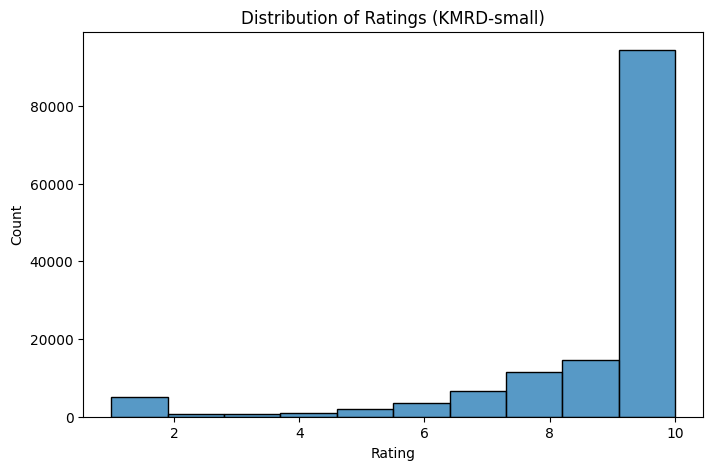

In [28]:
plt.figure(figsize=(8,5))
sns.histplot(df_kmrd_rates['rate'], bins=10, kde=False)
plt.title("Distribution of Ratings (KMRD-small)")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

사용자별 평점 분포 (|z| <= 3)

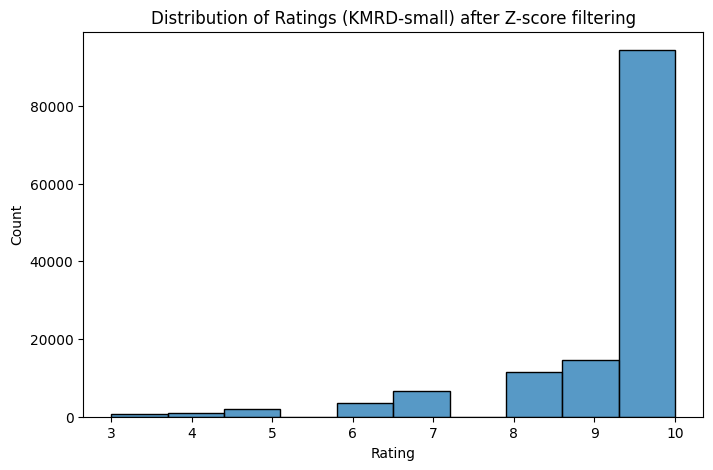

In [29]:
plt.figure(figsize=(8,5))
sns.histplot(df_kmrd_rates_zscore['rate'], bins=10, kde=False)
plt.title("Distribution of Ratings (KMRD-small) after Z-score filtering")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

사용자별 평점 분포 (리뷰가 30개 이상인 사용자)

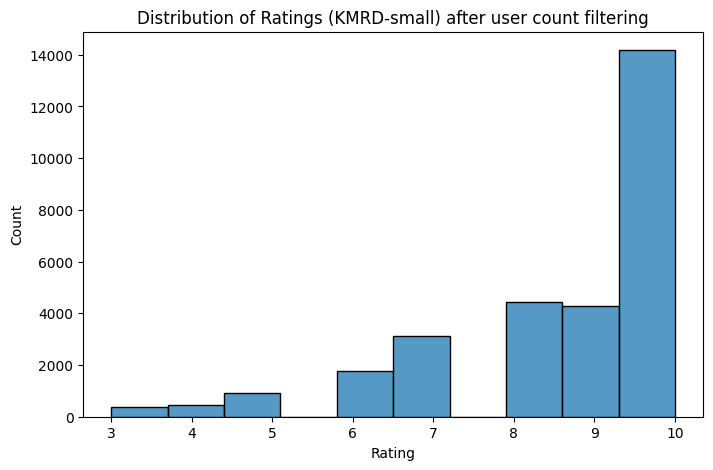

In [30]:
plt.figure(figsize=(8,5))
sns.histplot(df_kmrd_rates_rating_count['rate'], bins=10, kde=False)
plt.title("Distribution of Ratings (KMRD-small) after user count filtering")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

##### 가장 많이 평가된 영화

In [31]:
movie_rating_counts = df_kmrd_rates.groupby('movie')['rate'].count().sort_values(ascending=False)

df_kmrd_movies['movie'] = df_kmrd_movies['movie'].astype(int)
movie_rating_counts = movie_rating_counts.reset_index().merge(df_kmrd_movies, how='left', left_on='movie', right_on='movie')
movie_rating_counts = movie_rating_counts.sort_values(by='rate', ascending=False)
movie_rating_counts = movie_rating_counts.rename(columns={'rate': 'rating_count'})
movie_rating_counts = movie_rating_counts.drop(['year_original', 'year_korea', 'grade'], axis=1)
print("Top 10 most rated movies:")
print(movie_rating_counts.head(10))

Top 10 most rated movies:
   movie  rating_count     title_kor                   title_eng
0  10200          7264  터미네이터 2:오리지널  Terminator 2: Judgment Day
1  10048          7014     죽은 시인의 사회          Dead Poets Society
2  10102          4391     사운드 오브 뮤직          The Sound Of Music
3  10016          4028       나 홀로 집에                  Home Alone
4  10936          3690           가위손         Edward Scissorhands
5  10001          3635        시네마 천국             Cinema Paradiso
6  10002          3004      빽 투 더 퓨쳐          Back To The Future
7  10071          2960            대부  Mario Puzo's The Godfather
8  10114          2901         아마데우스                     Amadeus
9  10110          2213          영웅본색    英雄本色 , A Better Tomorrow


In [32]:
movie_rating_counts_zscore = df_kmrd_rates_zscore.groupby('movie')['rate'].count().sort_values(ascending=False)

df_kmrd_movies['movie'] = df_kmrd_movies['movie'].astype(int)
movie_rating_counts_zscore = movie_rating_counts_zscore.reset_index().merge(df_kmrd_movies, how='left', left_on='movie', right_on='movie')
movie_rating_counts_zscore = movie_rating_counts_zscore.sort_values(by='rate', ascending=False)
movie_rating_counts_zscore = movie_rating_counts_zscore.rename(columns={'rate': 'rating_count'})
movie_rating_counts_zscore = movie_rating_counts_zscore.drop(['year_original', 'year_korea', 'grade'], axis=1)
print("Top 10 most rated movies (|z|<=3):")
print(movie_rating_counts_zscore.head(10))

Top 10 most rated movies (|z|<=3):
   movie  rating_count     title_kor                   title_eng
0  10200          6933  터미네이터 2:오리지널  Terminator 2: Judgment Day
1  10048          6759     죽은 시인의 사회          Dead Poets Society
2  10102          4179     사운드 오브 뮤직          The Sound Of Music
3  10016          3873       나 홀로 집에                  Home Alone
4  10936          3530           가위손         Edward Scissorhands
5  10001          3469        시네마 천국             Cinema Paradiso
6  10002          2905      빽 투 더 퓨쳐          Back To The Future
7  10114          2803         아마데우스                     Amadeus
8  10071          2801            대부  Mario Puzo's The Godfather
9  10110          2123          영웅본색    英雄本色 , A Better Tomorrow


In [33]:
movie_rating_counts_rating_count = df_kmrd_rates_rating_count.groupby('movie')['rate'].count().sort_values(ascending=False)

df_kmrd_movies['movie'] = df_kmrd_movies['movie'].astype(int)
movie_rating_counts_rating_count = movie_rating_counts_rating_count.reset_index().merge(df_kmrd_movies, how='left', left_on='movie', right_on='movie')
movie_rating_counts_rating_count = movie_rating_counts_rating_count.sort_values(by='rate', ascending=False)
movie_rating_counts_rating_count = movie_rating_counts_rating_count.rename(columns={'rate': 'rating_count'})
movie_rating_counts_rating_count = movie_rating_counts_rating_count.drop(['year_original', 'year_korea', 'grade'], axis=1)
print("Top 10 most rated movies (user count >= 30):")
print(movie_rating_counts_rating_count.head(10))

Top 10 most rated movies (user count >= 30):
   movie  rating_count     title_kor                   title_eng
0  10048           793     죽은 시인의 사회          Dead Poets Society
1  10200           779  터미네이터 2:오리지널  Terminator 2: Judgment Day
2  10936           569           가위손         Edward Scissorhands
3  10016           520       나 홀로 집에                  Home Alone
4  10102           497     사운드 오브 뮤직          The Sound Of Music
5  10001           494        시네마 천국             Cinema Paradiso
6  10071           442            대부  Mario Puzo's The Godfather
7  10002           430      빽 투 더 퓨쳐          Back To The Future
8  10114           403         아마데우스                     Amadeus
9  10110           306          영웅본색    英雄本色 , A Better Tomorrow


In [34]:
# top_rated_movies_all = set(movie_rating_counts['movie'].head(5)) & set(movie_rating_counts_zscore['movie'].head(5)) & set(movie_rating_counts_rating_count['movie'].head(5))
# top_rated_movies_all = df_kmrd_movies[df_kmrd_movies['movie'].astype(int).isin(top_rated_movies_all)].drop(['year_original', 'year_korea', 'grade'], axis=1)
# print("Top 10 most rated movies in all 3 datasets:")
# print(top_rated_movies_all)

##### 가장 높은 평균 평점을 받은 영화

In [35]:
movie_rating_means = df_kmrd_rates.groupby('movie')['rate'].mean().sort_values(ascending=False)
movie_rating_means = movie_rating_means.reset_index().merge(df_kmrd_movies, how='left', left_on='movie', right_on='movie')
movie_rating_means = movie_rating_means.sort_values(by='rate', ascending=False)
movie_rating_means = movie_rating_means.rename(columns={'rate': 'rating_mean'})
movie_rating_means = movie_rating_means.drop(['title_eng', 'year_original', 'year_korea', 'grade'], axis=1)
print("Top 10 highest rated movies:")
print(movie_rating_means.head(10))

Top 10 highest rated movies:
   movie  rating_mean     title_kor
0  10974       10.000           쥬리아
5  10518       10.000            비황
7  10384       10.000            여로
6  10937       10.000        위기의 여자
1  10895       10.000        피부 깊숙이
4  10510       10.000          성춘향전
3  10180       10.000  대통령을 만드는 사람들
2  10799       10.000       내 친구 제제
8  10094        9.875         마이 웨이
9  10499        9.800     저 하늘에 태양이


In [36]:
movie_rating_means_zscore = df_kmrd_rates_zscore.groupby('movie')['rate'].mean().sort_values(ascending=False)
movie_rating_means_zscore = movie_rating_means_zscore.reset_index().merge(df_kmrd_movies, how='left', left_on='movie', right_on='movie')
movie_rating_means_zscore = movie_rating_means_zscore.sort_values(by='rate', ascending=False)
movie_rating_means_zscore = movie_rating_means_zscore.rename(columns={'rate': 'rating_mean'})
movie_rating_means_zscore = movie_rating_means_zscore.drop(['title_eng', 'year_original', 'year_korea', 'grade'], axis=1)
print("Top 10 highest rated movies (|z|<=3):")
print(movie_rating_means_zscore.head(10))

Top 10 highest rated movies (|z|<=3):
    movie  rating_mean     title_kor
0   10337         10.0          빌리티스
6   10510         10.0          성춘향전
10  10384         10.0            여로
1   10895         10.0        피부 깊숙이
8   10601         10.0        버스 정류장
7   10974         10.0           쥬리아
9   10937         10.0        위기의 여자
5   10180         10.0  대통령을 만드는 사람들
4   10518         10.0            비황
3   10527         10.0       사랑을 합시다


In [37]:
movie_rating_means_rating_user_review_count = df_kmrd_rates_rating_count.groupby('movie')['rate'].mean().sort_values(ascending=False)
movie_rating_means_rating_user_review_count = movie_rating_means_rating_user_review_count.reset_index().merge(df_kmrd_movies, how='left', left_on='movie', right_on='movie')
movie_rating_means_rating_user_review_count = movie_rating_means_rating_user_review_count.sort_values(by='rate', ascending=False)
movie_rating_means_rating_user_review_count = movie_rating_means_rating_user_review_count.rename(columns={'rate': 'rating_mean'})
movie_rating_means_rating_user_review_count = movie_rating_means_rating_user_review_count.drop(['title_eng', 'year_original', 'year_korea', 'grade'], axis=1)
print("Top 10 highest rated movies (user review count >= 30):")
print(movie_rating_means_rating_user_review_count.head(10))

Top 10 highest rated movies (user review count >= 30):
   movie  rating_mean     title_kor
0  10946    10.000000         공룡 선생
5  10471    10.000000       제3의 사나이
7  10354    10.000000           아리랑
6  10426    10.000000           수업료
8  10757    10.000000  적 그리고 사랑 이야기
4  10567    10.000000            야행
3  10180    10.000000  대통령을 만드는 사람들
2  10601    10.000000        버스 정류장
1  10910    10.000000      레이디 인 블랙
9  10200     9.703466  터미네이터 2:오리지널


In [38]:
movie_ratings_means_movie_rating_counts = df_filtered.groupby('movie')['rate'].mean().sort_values(ascending=False)
movie_ratings_means_movie_rating_counts = movie_ratings_means_movie_rating_counts.reset_index().merge(df_kmrd_movies, how='left', left_on='movie', right_on='movie')
movie_ratings_means_movie_rating_counts = movie_ratings_means_movie_rating_counts.sort_values(by='rate', ascending=False)
movie_ratings_means_movie_rating_counts = movie_ratings_means_movie_rating_counts.rename(columns={'rate': 'rating_mean'})
movie_ratings_means_movie_rating_counts = movie_ratings_means_movie_rating_counts.drop(['title_eng', 'year_original', 'year_korea', 'grade'], axis=1)
print("Top 10 highest rated movies (>=30 ratings):")
print(movie_ratings_means_movie_rating_counts.head(10))

Top 10 highest rated movies (>=30 ratings):
   movie  rating_mean       title_kor
0  10294     9.764706  브이 - 5부작 미니시리즈
1  10354     9.756410             아리랑
2  10940     9.580882              베어
3  10183     9.505263            맹룡과강
4  10306     9.489286          프로젝트 A
5  10405     9.481928           라임라이트
6  10588     9.469512     수잔 브링크의 아리랑
7  10472     9.469388     은행털이와 아빠와 나
8  10301     9.462766          시티 라이트
9  10284     9.437500         마농의 샘 2


##### 시간에 따른 평점의 변화나 패턴

In [39]:
df_kmrd_rates['datetime'] = pd.to_datetime(df_kmrd_rates['time'], unit='s', errors='coerce')

def plot_movie_rating_trend(movie_id):
    """
    For the given movie, group by month (or any time period),
    compute average rating, then plot a line chart over time.
    """
    df_movie = df_kmrd_rates[df_kmrd_rates['movie'] == movie_id].copy()
    if df_movie.empty:
        print(f"No rating data for movie_id={movie_id}")
        return
    
    df_movie['year_month'] = df_movie['datetime'].dt.to_period('M')
    trend = df_movie.groupby('year_month')['rate'].mean().reset_index()
    trend['year_month'] = trend['year_month'].astype(str)
    
    trend.sort_values('year_month', inplace=True)
    
    title_info = df_kmrd_movies.loc[df_kmrd_movies['movie'] == str(movie_id)]
    if not title_info.empty:
        movie_title = title_info.iloc[0]['title_kor'] or title_info.iloc[0]['title_eng']
    else:
        movie_title = f"Movie {movie_id}"
    
    plt.figure(figsize=(8,4))
    if len(trend) <= 12:
        plt.xticks(rotation=45)
    else:
        plt.xticks(np.arange(0, len(trend), 8), trend['year_month'][::8], rotation=45)
    plt.plot(trend['year_month'], trend['rate'], marker='o')
    plt.title(f"Average Monthly Rating for {movie_title} (movie_id={movie_id})")
    plt.xlabel("Year-Month")
    plt.ylabel("Average Rating")
    plt.tight_layout()
    plt.show()

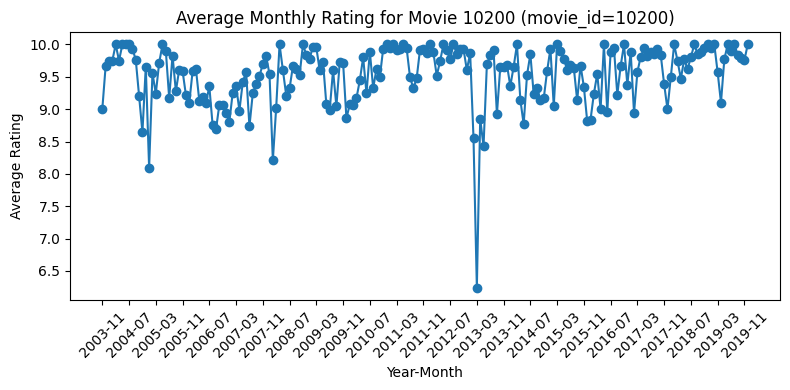

In [40]:
top_movie_id = movie_rating_counts.iloc[0]['movie']
plot_movie_rating_trend(top_movie_id)

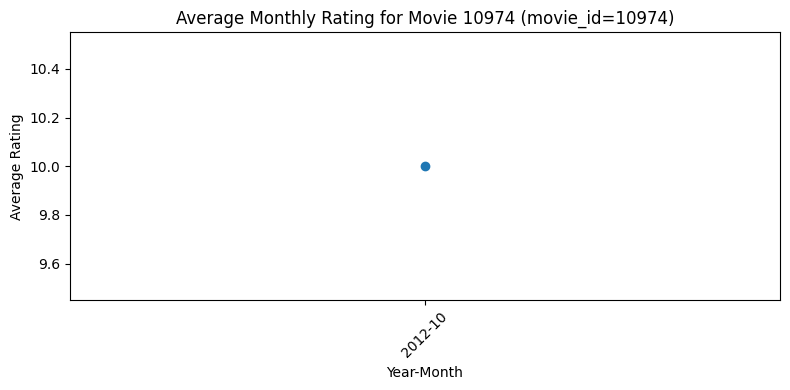

In [41]:
most_rated_movie_id = movie_rating_means.iloc[0]['movie']
plot_movie_rating_trend(most_rated_movie_id)

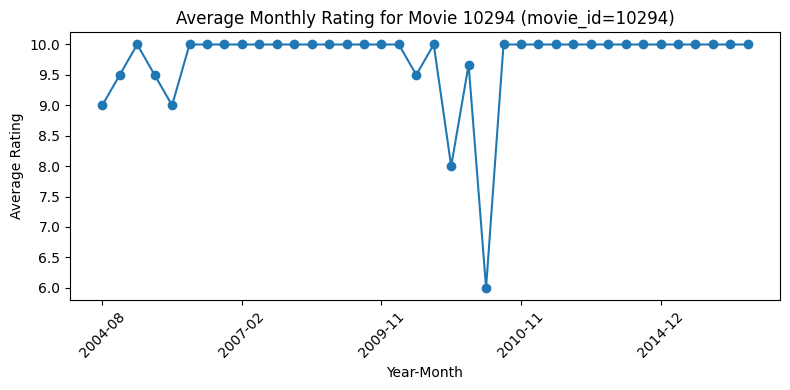

In [42]:
most_rated_movie_id = movie_ratings_means_movie_rating_counts.iloc[0]['movie']
plot_movie_rating_trend(most_rated_movie_id)
# 4719,10294,6,1283089200

In [43]:
movie_id_input = widgets.Text(
    value='',
    placeholder='Enter a movie ID (e.g., 10200)',
    description='Movie ID:',
    disabled=False
)

plot_button = widgets.Button(
    description='Plot!',
    disabled=False,
    button_style='',
    tooltip='Click to plot',
    icon='check'
)

def on_plot_button_clicked(b):
    clear_output(wait=True)
    
    display(movie_id_input, plot_button)
    
    movie_id_str = movie_id_input.value.strip()
    if not movie_id_str.isdigit():
        print("Please enter a valid numeric movie ID.")
        return
    
    movie_id_val = int(movie_id_str)
    
    plot_movie_rating_trend(movie_id_val)

plot_button.on_click(on_plot_button_clicked)

display(movie_id_input, plot_button)


Text(value='', description='Movie ID:', placeholder='Enter a movie ID (e.g., 10200)')

Button(description='Plot!', icon='check', style=ButtonStyle(), tooltip='Click to plot')

## 결론

- 유저들은 대체로 8점 이상의 평점을 많이 주는 경향이 있다.

## 참고자료

- [30명이면 된다고? 회의에서 당당하게, 설문조사를 알아보자.](http://triviaz.net/blog:easy_clt_survey)